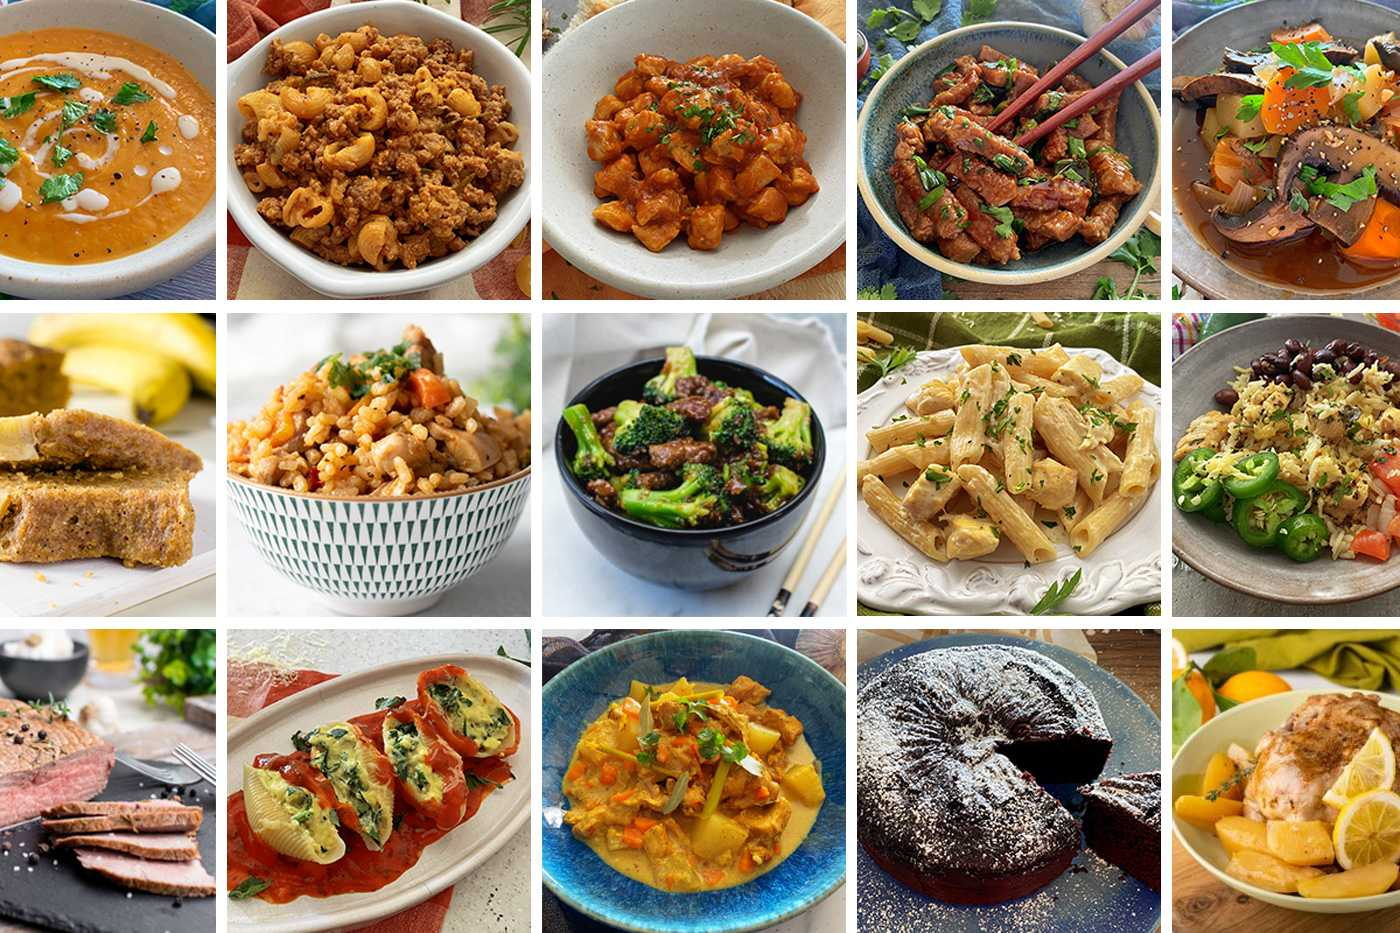

In [1]:
#show picture
from IPython.display import Image
Image(filename='Instant-Pot-Recipes.jpg')

# Objective: Increase site traffic by predicting recipe popularity

    - Create a written report to summarize the analysis you have performed and your findings.

        ● Data validation:
            ○ Describe validation and cleaning steps for every column in the data

        ● Exploratory Analysis to answer the customer questions ensuring you include:
            ○ Two different types of graphic showing single variables only
            ○ At least one graphic showing two or more variables
            ○ Description of your findings
        ● Model Development including:
            ○ What type of problem this is
            ○ Fitting a baseline model
            ○ Fitting a comparison model

        ● Model evaluation
            ○ Show how the two models compare

        ● Definition of a metric for the business to monitor
            ○ How should the business monitor what they want to achieve?
            ○ Estimate the initial value(s) for the metric based on the current data?
            
        ● Final summary including recommendations that the business should undertake
            - Prepare and deliver a presentation of max 10 slides to the product owner.

# Environment Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

#allow plots to appear directly in the notebook
%matplotlib inline
#show all columns in pandas
pd.set_option('display.max_columns', None)

In [3]:
#function to see percentage of missing values
def missing_values(df):
    missing = pd.DataFrame(df.isnull().sum())
    missing['%'] = round((missing[0]/len(df))*100, 2)
    missing.columns = ['Missing Values', '%']
    return missing.sort_values(by='Missing Values', ascending=False)

#function to plot disribution of all variables in a dataframe with dtype = int64 or float64
def plot_distributions(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            sns.distplot(df[col])
            plt.show()
            
#function to check for outliers in a dataframe with dtype = int64 or float64
def check_outliers(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            sns.boxplot(df[col])
            plt.show()
            
#function to remove outliers with iqr method 
def remove_outliers(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - (1.5 * iqr)
            upper = q3 + (1.5 * iqr)
            df = df[(df[col] > lower) & (df[col] < upper)]
    return df

#function to remove outliers with z method and threshold of 3
def remove_outliers_z(df):
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            z = np.abs(stats.zscore(df[col]))
            df = df[(z < 3)]
    return df

# Importing dataset

In [4]:
#import data
df = pd.read_csv('recipe_site_traffic_2212.csv')

## Checking the dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [6]:
df.shape

(947, 8)

    The data is as follows:

    - Recipe: Has a unique identificator which is an integer64              0% of nulls
    - Calories: Float indicating number of calories                         5.5% of nulls
    - Carbohydrate: Float indicating amount of carbohydrates                5.5% of nulls
    - Sugar: Float indicating amount of sugar                               5.5% of nulls
    - Protein: Float indicating amount of proteins                          5.5% of nulls
    - Category: String with 10 categories of food                           0% of nulls
    - Servings: String indicating a number with no of people                0% of nulls
    - High Traffic: String indicating whether there is high traffic or not  0% of nulls

In [7]:
missing_values(df)

,Missing Values,%
high_traffic,373,39.39
calories,52,5.49
carbohydrate,52,5.49
sugar,52,5.49
protein,52,5.49
recipe,0,0.00
category,0,0.00
servings,0,0.00


In [8]:
#checking head and tail of df to see if it conforms with what we have seen so far
df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


In [9]:
#set index to recipe 
df.set_index('recipe', inplace=True)

# Data Preparation

    After having a sneak peak at the data, here is a to do list to make it ready to start with EDA, feature engineering and rest of pipeline

        - Check categories and dummify accordingly without duplicates
        - Check nulls and come up with an strategy 
        - Convert servings to an integer, no reason for a string to be there
        - Convert y objective variable to a boolean with 0 or 1 for low and high traffic
    

## Patching Up Servings feature

In [10]:
#show unique values for servings
df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

In [11]:
#deleting " as a snack" from servings
df['servings'] = df['servings'].str.replace(' as a snack', '')

In [12]:
df['servings'].unique()

array(['6', '4', '1', '2'], dtype=object)

In [13]:
#convert servings to int
df['servings'] = df['servings'].astype(int)

## Checking target variable

In [14]:
df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [15]:
#convert "High" to 1 and "nan" to 0, and set dtype as bool
df['high_traffic'] = df['high_traffic'].replace('High', 1)
df['high_traffic'] = df['high_traffic'].fillna(0)
df['high_traffic'] = df['high_traffic'].astype(bool)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    int64  
 6   high_traffic  947 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(1)
memory usage: 52.7+ KB


## Previsualization of df

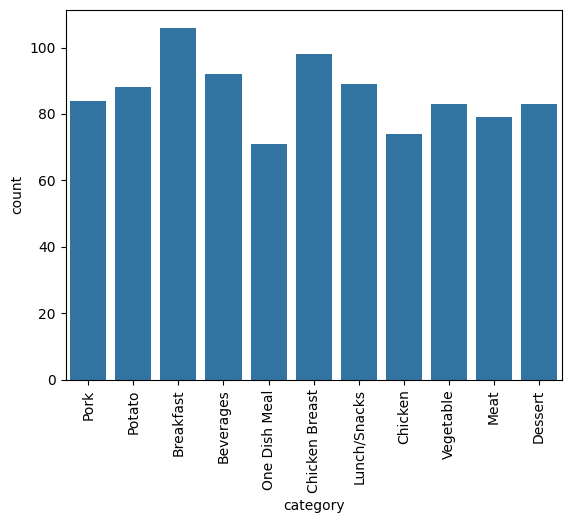

In [17]:
#barplot of df_nulls with x axis category and y axis number of nulls
sns.countplot(x='category', data=df)
plt.xticks(rotation=90)
plt.show()

## Dealing with nulls

In [18]:
#show nulls in df
df.isnull().sum()
 

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [19]:
#subset with rows with nulls
df_nulls = df[df.isnull().any(axis=1)]
df_nulls

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,True
24,NaN,NaN,NaN,NaN,Meat,2,False
49,NaN,NaN,NaN,NaN,Chicken Breast,4,False
83,NaN,NaN,NaN,NaN,Meat,4,True
90,NaN,NaN,NaN,NaN,Pork,6,True
117,NaN,NaN,NaN,NaN,Chicken Breast,6,True
122,NaN,NaN,NaN,NaN,Dessert,2,True
137,NaN,NaN,NaN,NaN,One Dish Meal,2,True
150,NaN,NaN,NaN,NaN,Potato,2,True


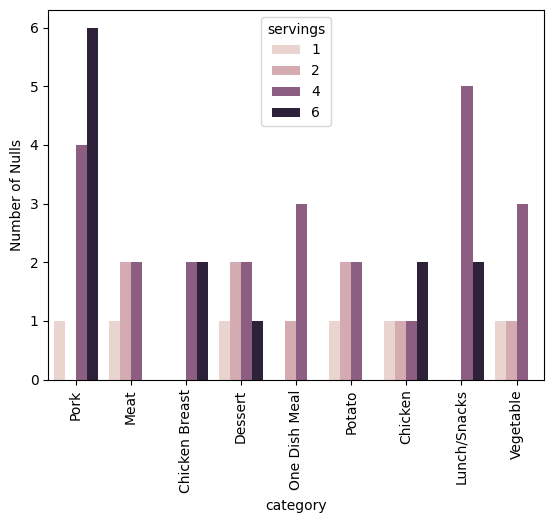

In [20]:
#barplot of df_nulls with x axis category and y axis number of nulls

sns.countplot(x='category', data=df_nulls, hue='servings')
plt.xticks(rotation=90)
#y tick title
plt.ylabel('Number of Nulls')
plt.show()


There appear to be many categories overlapping itself and some names are misleading, we will take care of that later

In [21]:
#for each category in category column, show mean, std, min, max, and quartiles for calories, carbohydrate, sugar and protein
for category in df['category'].unique():
    print(category)
    print(df[df['category'] == category][['calories', 'carbohydrate', 'sugar', 'protein']].describe())
    print('\n')

Pork
          calories  carbohydrate      sugar     protein
count    73.000000     73.000000  73.000000   73.000000
mean    629.708082     28.076164   8.040137   43.797671
std     624.531554     25.668843   9.293900   46.481453
min       1.560000      0.470000   0.080000    1.320000
25%     144.280000      7.520000   1.890000   13.870000
50%     399.260000     19.560000   5.230000   29.820000
75%     951.740000     42.530000   9.400000   52.000000
max    2906.010000    111.080000  49.530000  189.330000


Potato
          calories  carbohydrate      sugar    protein
count    83.000000     83.000000  83.000000  83.000000
mean    425.068554     58.150361   3.718916   8.574217
std     374.508334     80.949176   3.256371   9.347805
min       9.260000      0.050000   0.010000   0.000000
25%     139.645000     16.315000   1.225000   2.960000
50%     269.460000     32.540000   2.640000   5.900000
75%     611.000000     61.805000   5.250000   9.685000
max    2068.070000    530.420000  13.44000

## Inputting nulls with median
It appears to be a big difference between the min and the max for each of the categories so the strategy in this case is to input the df with the median instead of mean as it is more robust to outliers and can preserve better the data distribution

In [22]:
#input median values for nans in df for calories, carbohydrate, sugar and protein
df['calories'] = df['calories'].fillna(df['calories'].median())
df['carbohydrate'] = df['carbohydrate'].fillna(df['carbohydrate'].median())
df['sugar'] = df['sugar'].fillna(df['sugar'].median())
df['protein'] = df['protein'].fillna(df['protein'].median())

#show percentage of nulls in df
missing_values(df) 

,Missing Values,%
calories,0,0.0
carbohydrate,0,0.0
sugar,0,0.0
protein,0,0.0
category,0,0.0
servings,0,0.0
high_traffic,0,0.0


# EDA of df before data wrangling

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


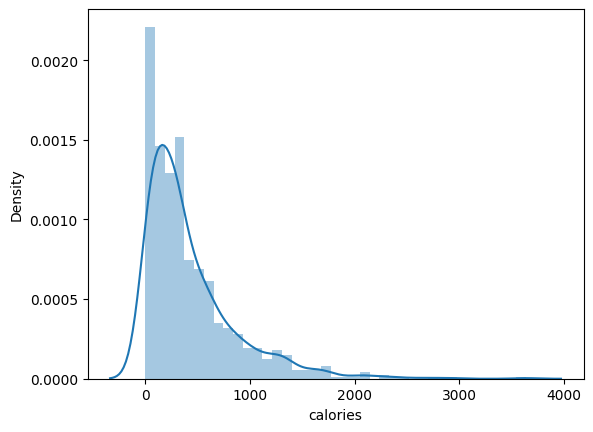

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


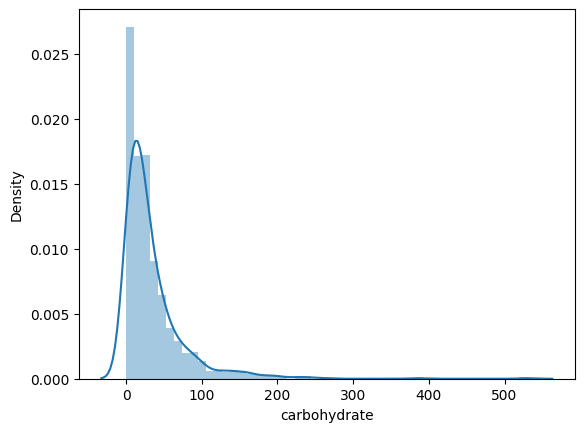

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


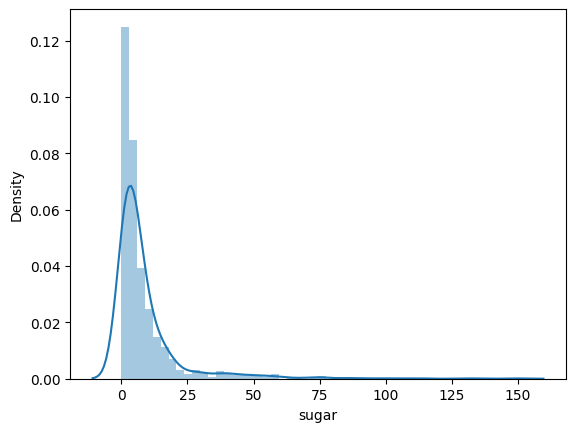

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


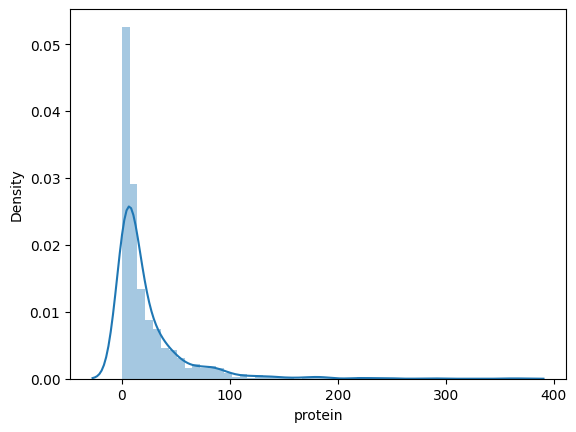

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


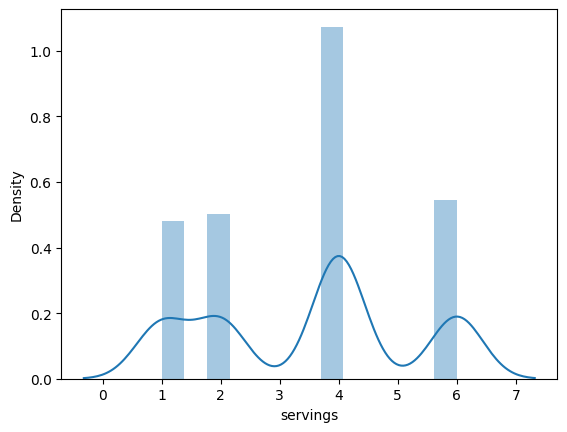

In [23]:
plot_distributions(df)

All distributions are skewed to the left, we will have to think of something later

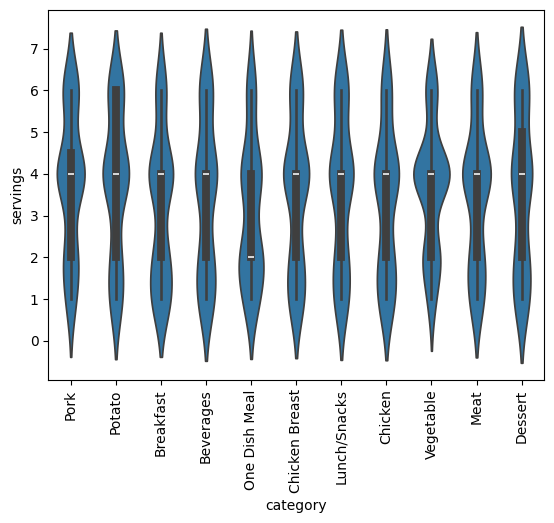

In [24]:
#show seaborn violinplot of servings and calories by category
sns.violinplot(x='category', y='servings', data=df)
plt.xticks(rotation=90)
plt.show()
 


<Figure size 3000x1500 with 0 Axes>

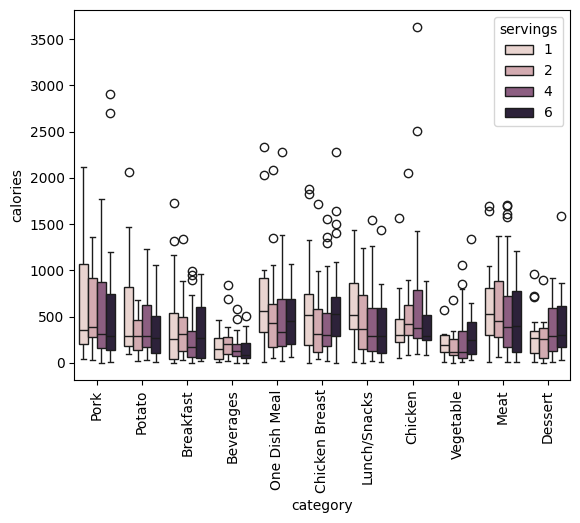

<Figure size 3000x1500 with 0 Axes>

In [25]:
#boxplot of calories and servings by category
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


## Boolean as number variables

In [26]:
# change boolean values to 1 and 0
df['high_traffic'] = df['high_traffic'].astype(int)


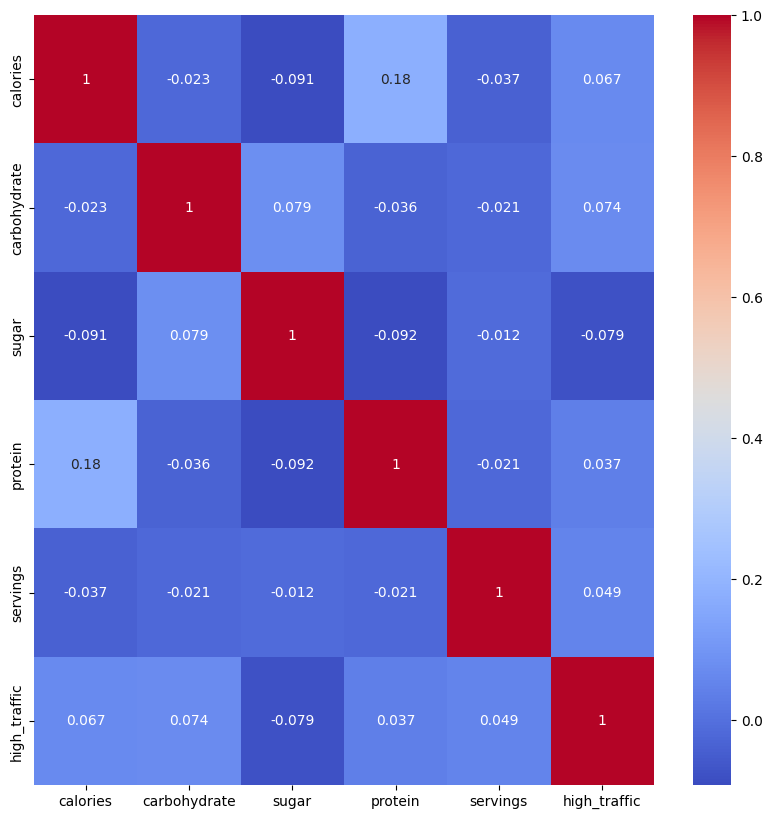

In [27]:
#correlation heatmap of df except category column
plt.figure(figsize=(10,10))
sns.heatmap(df.drop('category', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()
 



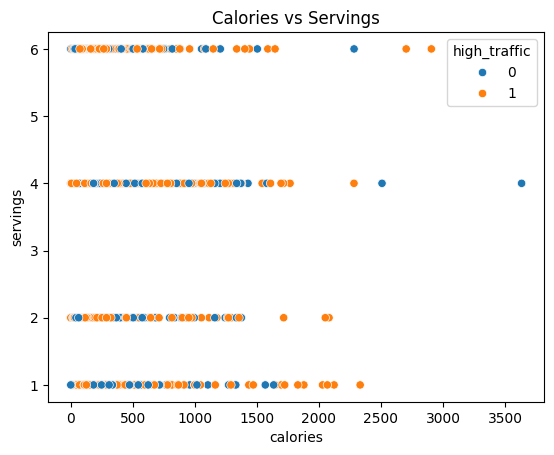

In [28]:
#scatterplot of calories and servings against high_traffic
plt.title('Calories vs Servings')
sns.scatterplot(x='calories', y='servings', data=df, hue='high_traffic')
plt.show()
 

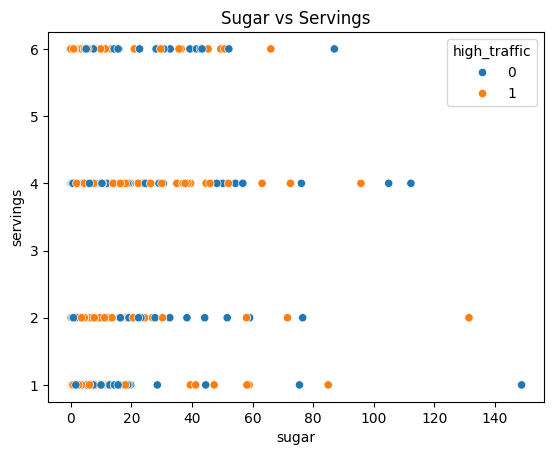

In [29]:
#scatterplot of sugar and servings against high_traffic
#title
plt.title('Sugar vs Servings')
sns.scatterplot(x='sugar', y='servings', data=df, hue='high_traffic')
plt.show()


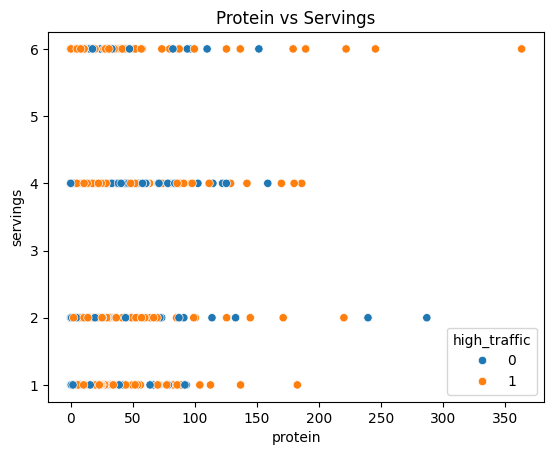

In [30]:
#scatterplot of protein and servings against high_traffic
plt.title('Protein vs Servings')
sns.scatterplot(x='protein', y='servings', data=df, hue='high_traffic')
plt.show()


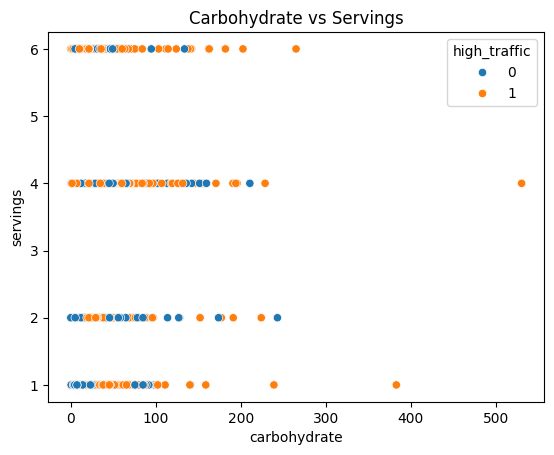

In [31]:
#scatterplot of carbohydrate and servings against high_traffic
plt.title('Carbohydrate vs Servings')
sns.scatterplot(x='carbohydrate', y='servings', data=df, hue='high_traffic')
plt.show()

# Data Wrangling

## Renaming and merging of categorical variables
Now let's handle the different categories

In [32]:
#distinct values in category column
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

In [33]:
#merge Chicken Breast and Chicken into Chicken
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
df['category'] = df['category'].replace('Chicken', 'Chicken')
df['category'].unique()



array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert'],
      dtype=object)

    - Chicken and Chicken Breast certainly do not add value separately.
    - Potato is part of the family Vegetables but from a cuisine perspective is not clear whether these are recipes wich its main ingredient its the potato or if rather Vegetables, more vegetables than potato are being used
    - For Meat, we could put Pork and Chicken under this category but it seems that this could potentially be Red Meat as in a beef steak, to avoid uncertainty this will be renamed
    - Lunch/ Snacks is quite confusing, if it is lunch it is certainly not a snack, given the amount of servings and calories I am renaming this to lunch only

In [34]:
#rename Meat to Red Meat
df['category'] = df['category'].replace('Meat', 'Red Meat')


In [35]:
#rename Lunch/Snacks to Lunch
df['category'] = df['category'].replace('Lunch/Snacks', 'Lunch')
df['category'].unique()

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken', 'Lunch', 'Vegetable', 'Red Meat', 'Dessert'],
      dtype=object)

## Checking for outliers

In [36]:
df.shape

(947, 7)

Let's do a random investigation to see where the outliers are

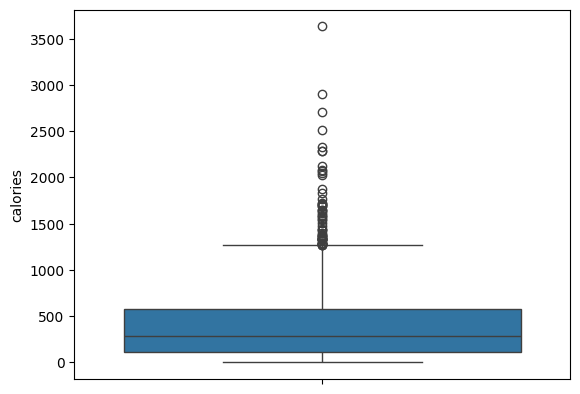

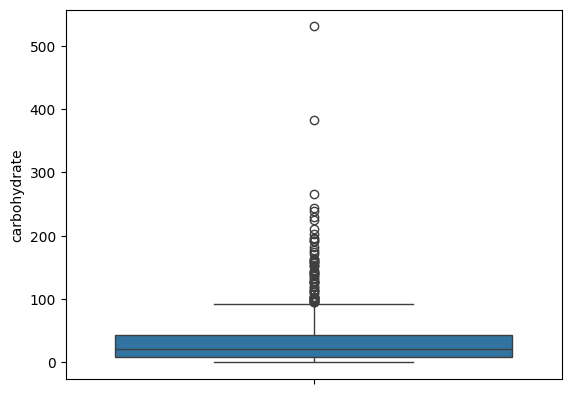

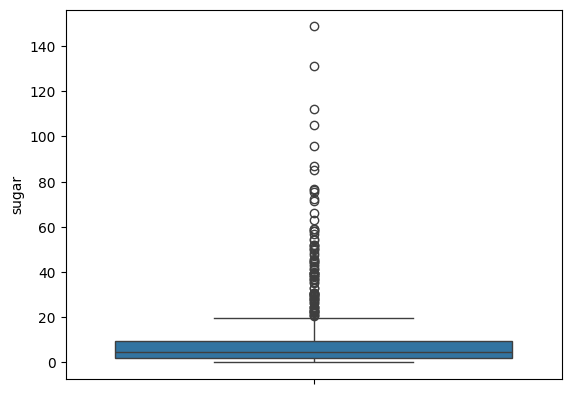

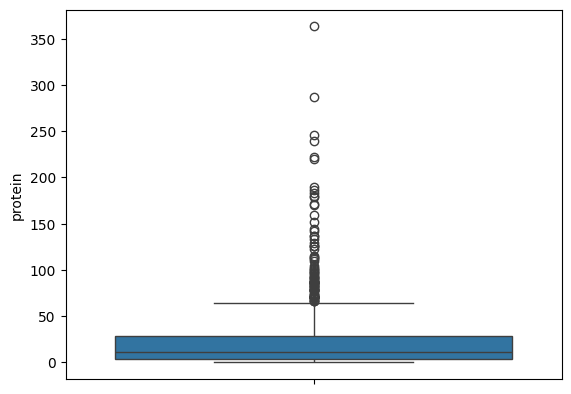

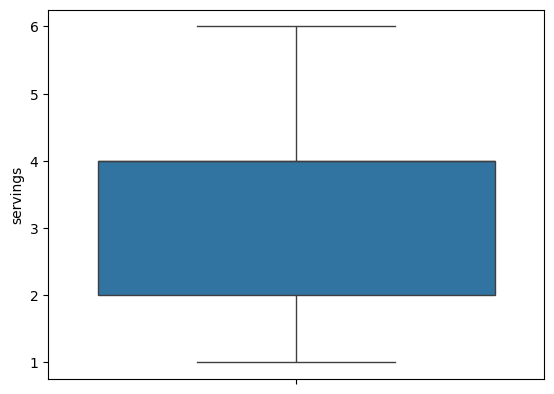

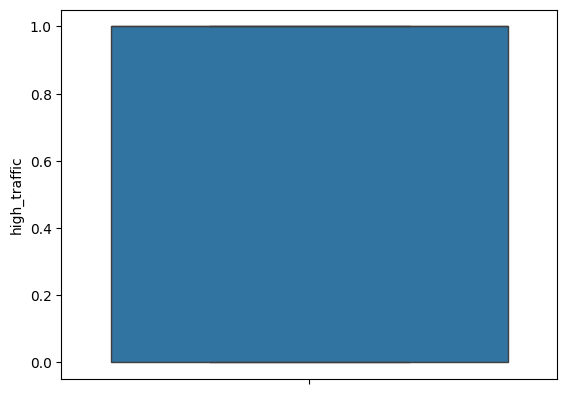

In [37]:
check_outliers(df)

    It looks like these outliers must be discriminated by the servings and the category they represent, we will do this manually

In [38]:
df.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings',
       'high_traffic'],
      dtype='object')

<Figure size 3000x1500 with 0 Axes>

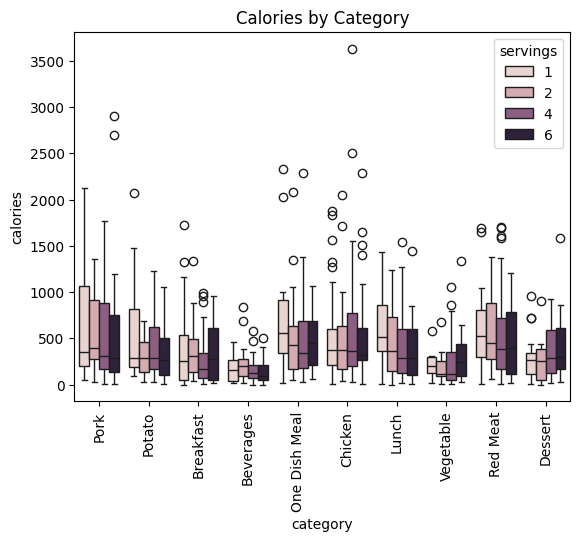

<Figure size 3000x1500 with 0 Axes>

In [39]:
#boxplot of calories and servings by category
plt.title('Calories by Category')
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
#title



## Selective outlier removal

In [40]:
#for category "Pork" and serings = 6, delete calories > 2500
df = df[~((df['category'] == 'Pork') & (df['servings'] == 6) & (df['calories'] > 2500))]
 
#for category "Potato" and servings = 1 delete calories > 1500
df = df[~((df['category'] == 'Potato') & (df['servings'] == 1) & (df['calories'] > 1500))]

#for category "Breakfast" and servings = 1 or 2 delete calories > 1200
df = df[~((df['category'] == 'Breakfast') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 1200))]

#for category "Breakfast" and servings = 3 delete calories > 700
df = df[~((df['category'] == 'Breakfast') & (df['servings'] == 3) & (df['calories'] > 700))]

#for category "Beverages" and all servings delete calories > 450
df = df[~((df['category'] == 'Beverages') & (df['calories'] > 450))]

#for category "One Dish Meal" and all servings delete calories > 1400
df = df[~((df['category'] == 'One Dish Meal') & (df['calories'] > 1400))]

#for category "Chicken Breast" and all servings delete calories > 1350
df = df[~((df['category'] == 'Chicken Breast') & (df['calories'] > 1350))]

#for category "Lunch/Snacks" and servings = 3 or 4 delete calories > 1350
df = df[~((df['category'] == 'Lunch/Snacks') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 1350))]

#for category "Chicken" and all servings delete calories > 1400
df = df[~((df['category'] == 'Chicken') & (df['calories'] > 1400))]

#for category "Vegetable" and servings = 1 or 2 delete calories > 500
df = df[~((df['category'] == 'Vegetable') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 500))]

#for category "Vegetable" and servings = 3 or 4 delete calories > 750
df = df[~((df['category'] == 'Vegetable') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 750))]

#for category "Meat" and all servings delete calories > 1400
df = df[~((df['category'] == 'Meat') & (df['calories'] > 1400))]

#for category "Desert" and servings = 1 or 2 delete calories > 500
df = df[~((df['category'] == 'Desert') & ((df['servings'] == 1) | (df['servings'] == 2)) & (df['calories'] > 500))]

#for category "Desert" and servings = 3 or 4 delete calories > 1200
df = df[~((df['category'] == 'Desert') & ((df['servings'] == 3) | (df['servings'] == 4)) & (df['calories'] > 1200))]





In [41]:
df.shape

(913, 7)

<Figure size 3000x1500 with 0 Axes>

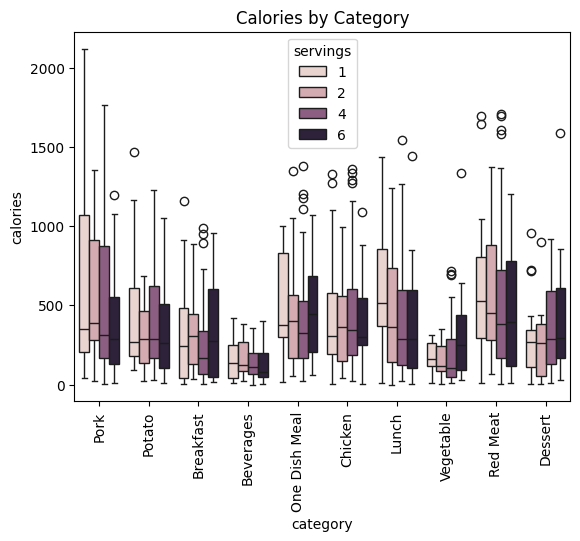

<Figure size 3000x1500 with 0 Axes>

In [42]:
#boxplot of calories and servings by category
plt.title('Calories by Category')
sns.boxplot(x='category', y='calories', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
#title

<Figure size 3000x1500 with 0 Axes>

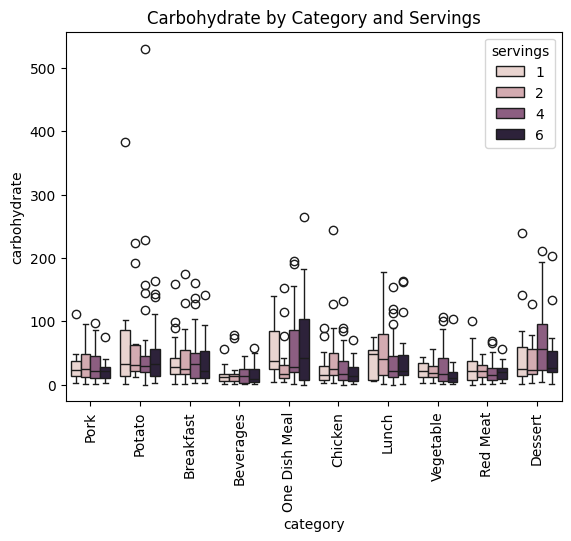

<Figure size 3000x1500 with 0 Axes>

In [43]:
#boxplot of carbohydrate and servings by category
plt.title('Carbohydrate by Category and Servings')
sns.boxplot(x='category', y='carbohydrate', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


In [44]:
#for all categories and servings, remove carbohydrate > 200
df = df[~(df['carbohydrate'] > 190)]

In [45]:
df.shape

(900, 7)

<Figure size 3000x1500 with 0 Axes>

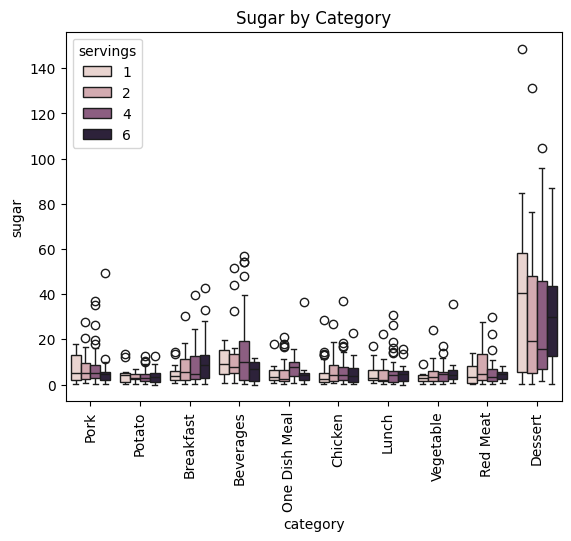

<Figure size 3000x1500 with 0 Axes>

In [46]:
#boxplot of sugar and servings by category
plt.title('Sugar by Category')
sns.boxplot(x='category', y='sugar', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))


In [47]:
# for categories Pork, Breakfast remove sugar > 25
#df = df[~((df['category'] == 'Pork') | (df['category'] == 'Breakfast')) & (df['sugar'] > 25)]

# for category Beverages remove sugar > 40
#df = df[~((df['category'] == 'Beverages') & (df['sugar'] > 40))]

# for category One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, and Vegetable remove sugar > 22
#df = df[~((df['category'] == 'One Dish Meal') | (df['category'] == 'Chicken Breast') | (df['category'] == 'Lunch/Snacks') | (df['category'] == 'Chicken') | (df['category'] == 'Vegetable')) & (df['sugar'] > 22)]

# for category Desert remove sugar > 95
df = df[~((df['category'] == 'Desert') & (df['sugar'] > 100))]



In [48]:
df.shape

(900, 7)

<Figure size 3000x1500 with 0 Axes>

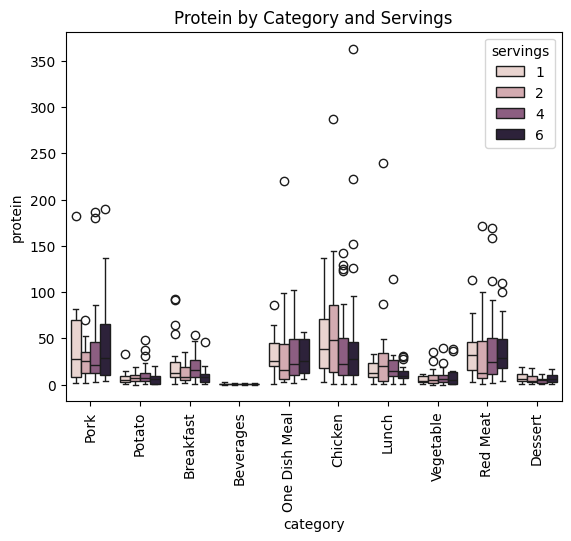

<Figure size 3000x1500 with 0 Axes>

In [49]:
#boxplot of protein and servings by category
plt.title('Protein by Category and Servings')
sns.boxplot(x='category', y='protein', data=df, hue='servings')
plt.xticks(rotation=90)
#size of plot
plt.figure(figsize=(30,15))
 
  

In [50]:
#for all categories and servings, remove protein > 150
df = df[~(df['protein'] > 150)]


In [51]:
df.shape

(887, 7)

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


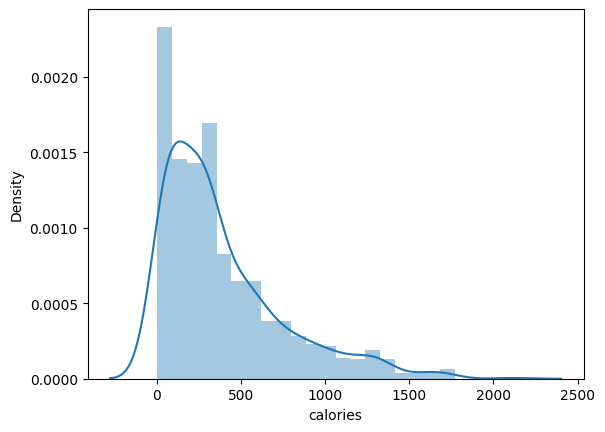

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


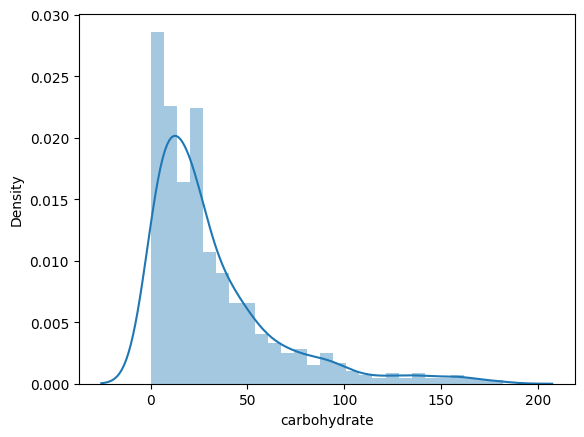

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


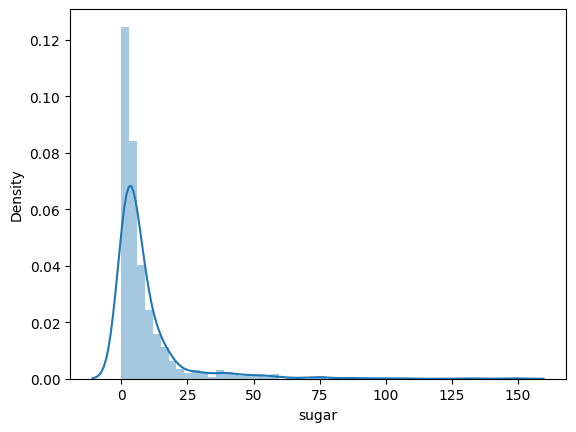

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


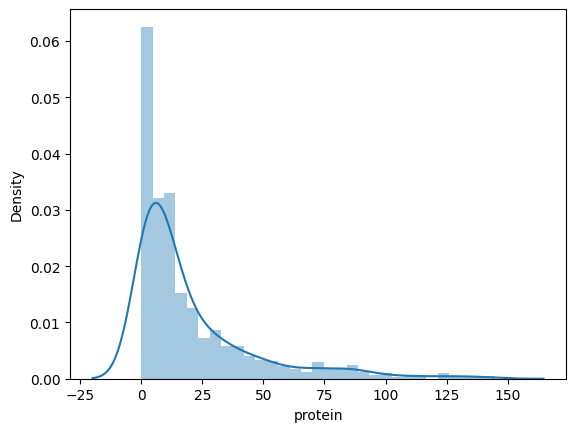

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


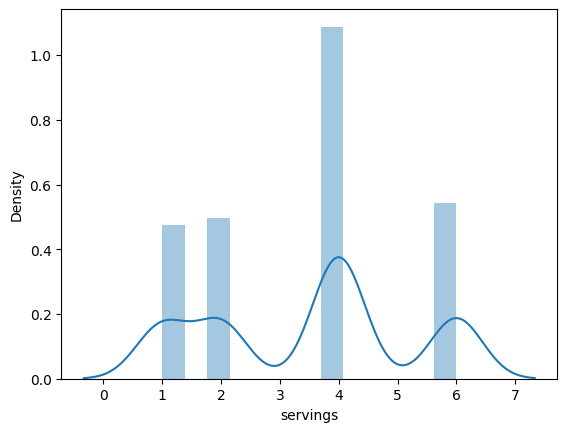

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


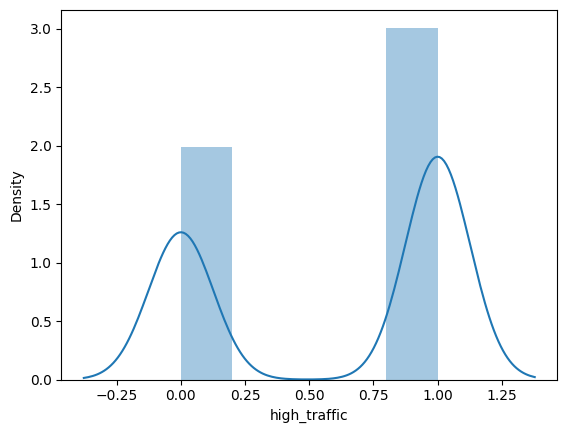

In [52]:
plot_distributions(df)

## Checking for correlation

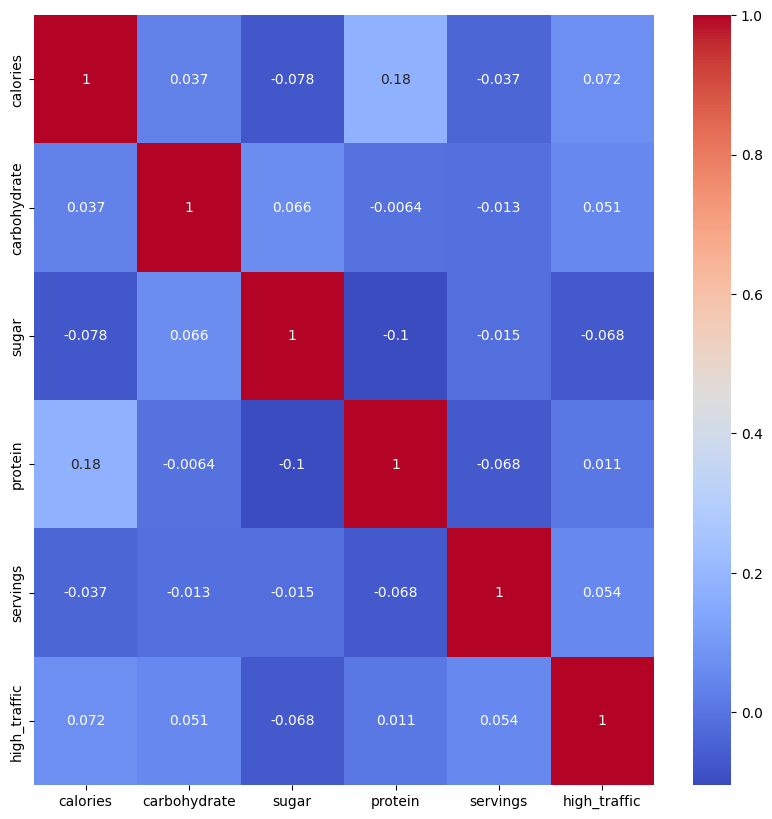

In [53]:
#correration heatmap of df except category column agains high_traffic
plt.figure(figsize=(10,10))
sns.heatmap(df.drop('category', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()
 
  


    Still, there is no clear correlation between variables

## Dummification

In [54]:
#Dummies for category column
df = pd.get_dummies(df, columns=['category'], drop_first=False, prefix='category')
df.head()

,calories,carbohydrate,sugar,protein,servings,high_traffic,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch,category_One Dish Meal,category_Pork,category_Potato,category_Red Meat,category_Vegetable
recipe,,,,,,,,,,,,,,,,
1,288.55,21.48,4.55,10.80,6,1,False,False,False,False,False,False,True,False,False,False
2,35.48,38.56,0.66,0.92,4,1,False,False,False,False,False,False,False,True,False,False
3,914.28,42.68,3.09,2.88,1,0,False,True,False,False,False,False,False,False,False,False
4,97.03,30.56,38.63,0.02,4,1,True,False,False,False,False,False,False,False,False,False
5,27.05,1.85,0.80,0.53,4,0,True,False,False,False,False,False,False,False,False,False


In [55]:
#position high_traffic column as last column
df = df[[col for col in df if col not in ['high_traffic']] + ['high_traffic']]
df.head()

,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch,category_One Dish Meal,category_Pork,category_Potato,category_Red Meat,category_Vegetable,high_traffic
recipe,,,,,,,,,,,,,,,,
1,288.55,21.48,4.55,10.80,6,False,False,False,False,False,False,True,False,False,False,1
2,35.48,38.56,0.66,0.92,4,False,False,False,False,False,False,False,True,False,False,1
3,914.28,42.68,3.09,2.88,1,False,True,False,False,False,False,False,False,False,False,0
4,97.03,30.56,38.63,0.02,4,True,False,False,False,False,False,False,False,False,False,1
5,27.05,1.85,0.80,0.53,4,True,False,False,False,False,False,False,False,False,False,0


In [56]:
df.dtypes

calories                  float64
carbohydrate              float64
sugar                     float64
protein                   float64
servings                    int64
category_Beverages           bool
category_Breakfast           bool
category_Chicken             bool
category_Dessert             bool
category_Lunch               bool
category_One Dish Meal       bool
category_Pork                bool
category_Potato              bool
category_Red Meat            bool
category_Vegetable           bool
high_traffic                int64
dtype: object

In [57]:
#pass all boolean dtype columns to int
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
        
        

In [58]:
#rename high_traffic column to popularity
df = df.rename(columns={'high_traffic': 'popularity'})

In [59]:
#pandas eda of df
df.describe()
 

,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch,category_One Dish Meal,category_Pork,category_Potato,category_Red Meat,category_Vegetable,popularity
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,385.252796,31.781973,8.787227,20.303608,3.488162,0.096956,0.116122,0.173619,0.089064,0.099211,0.071026,0.087937,0.092446,0.085682,0.087937,0.602029
std,361.415337,32.973025,14.113557,25.761100,1.726708,0.296065,0.320552,0.378995,0.284997,0.299114,0.257013,0.283363,0.289819,0.280052,0.283363,0.489755
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,111.660000,9.345000,1.805000,3.440000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,538.995000,41.805000,9.395000,26.070000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2122.240000,181.980000,148.750000,144.710000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering

In [63]:
df.shape

(887, 16)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887 entries, 1 to 947
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calories                887 non-null    float64
 1   carbohydrate            887 non-null    float64
 2   sugar                   887 non-null    float64
 3   protein                 887 non-null    float64
 4   servings                887 non-null    int64  
 5   category_Beverages      887 non-null    int64  
 6   category_Breakfast      887 non-null    int64  
 7   category_Chicken        887 non-null    int64  
 8   category_Dessert        887 non-null    int64  
 9   category_Lunch          887 non-null    int64  
 10  category_One Dish Meal  887 non-null    int64  
 11  category_Pork           887 non-null    int64  
 12  category_Potato         887 non-null    int64  
 13  category_Red Meat       887 non-null    int64  
 14  category_Vegetable      887 non-null    int64  

In [61]:
#perform a yeo-johnson transformation on calories, carbohydrate, sugar and protein to make them more normally distributed
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df[['calories', 'carbohydrate', 'sugar', 'protein']] = pt.fit_transform(df[['calories', 'carbohydrate', 'sugar', 'protein']])
df.head()


,calories,carbohydrate,sugar,protein,servings,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch,category_One Dish Meal,category_Pork,category_Potato,category_Red Meat,category_Vegetable,popularity
recipe,,,,,,,,,,,,,,,,
1,0.056613,0.028481,0.053689,0.041637,6,0,0,0,0,0,0,1,0,0,0,1
2,-1.418210,0.594509,-1.418608,-1.375496,4,0,0,0,0,0,0,0,1,0,0,1
3,1.343435,0.698965,-0.285469,-0.840193,1,0,1,0,0,0,0,0,0,0,0,0
4,-0.822332,0.362249,1.801352,-1.842467,4,1,0,0,0,0,0,0,0,0,0,1
5,-1.550215,-1.663283,-1.308219,-1.544664,4,1,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


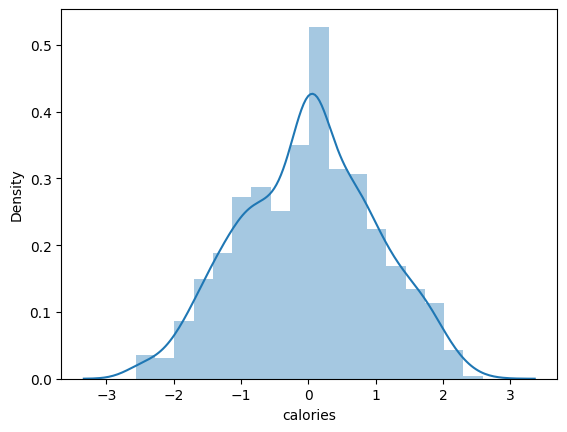

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


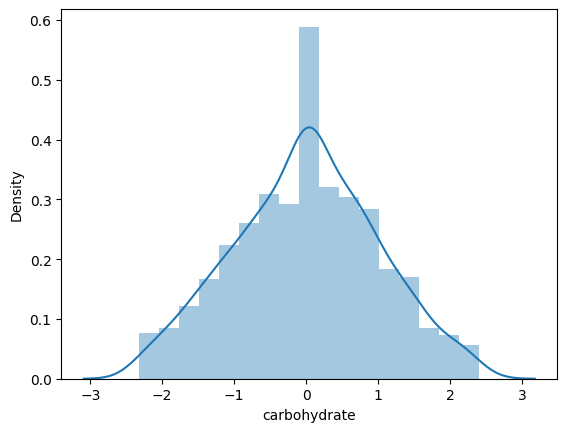

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


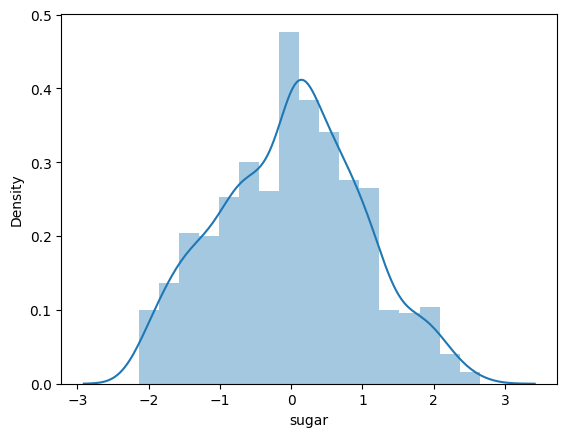

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


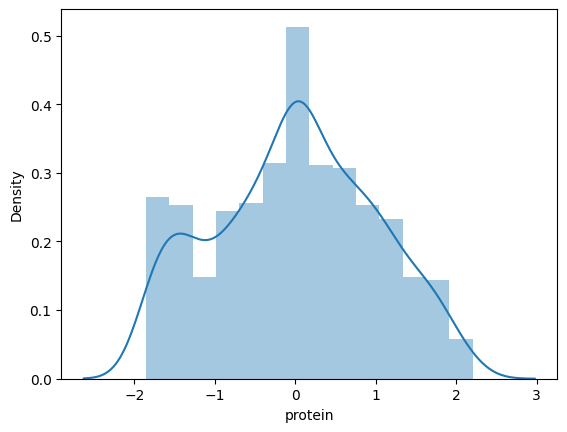

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


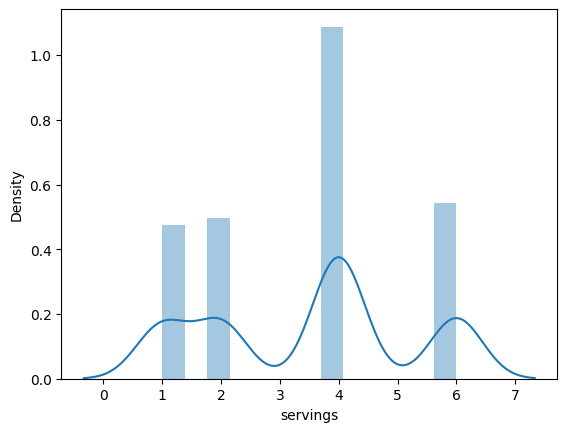

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


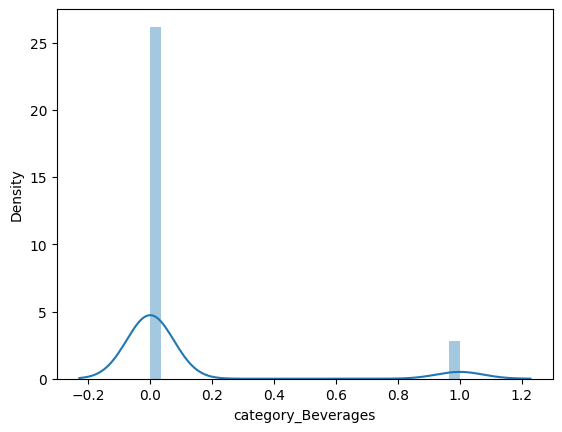

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


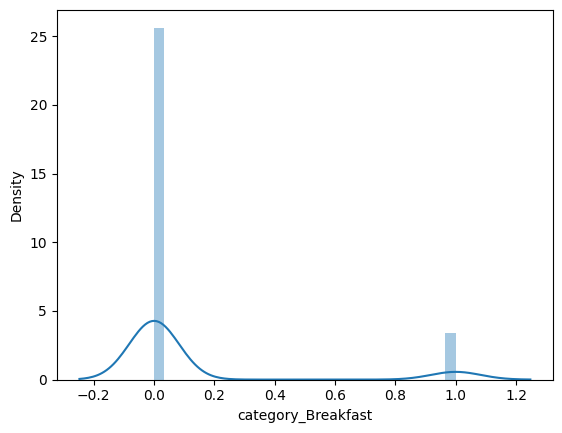

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


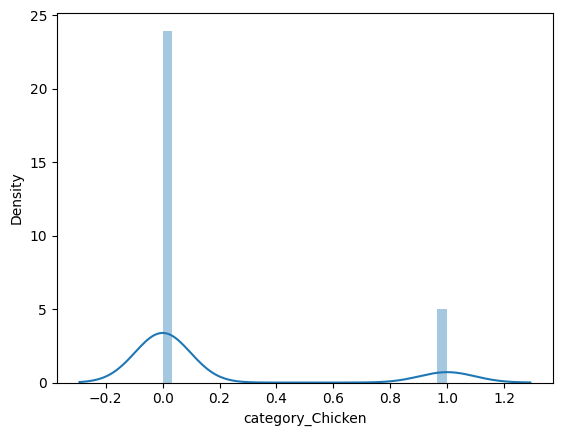

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


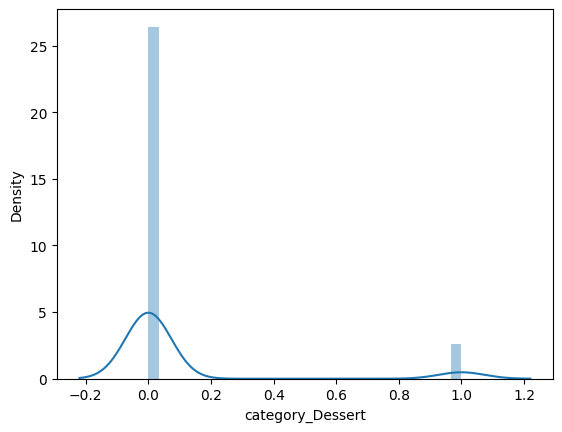

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


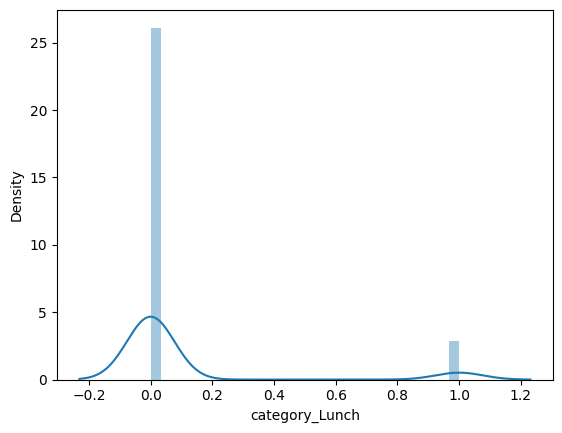

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


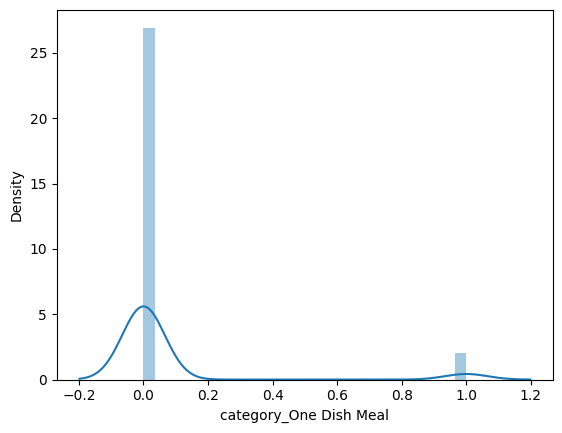

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


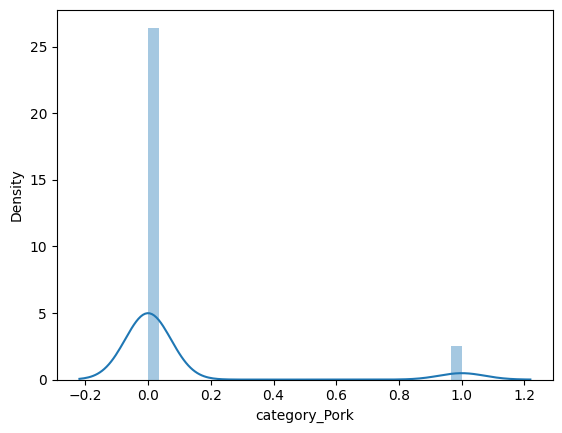

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


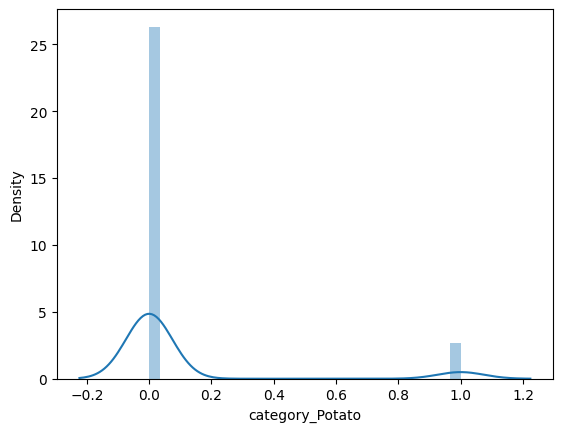

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


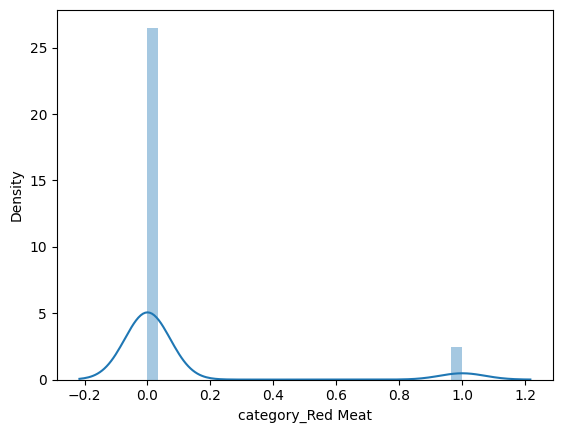

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


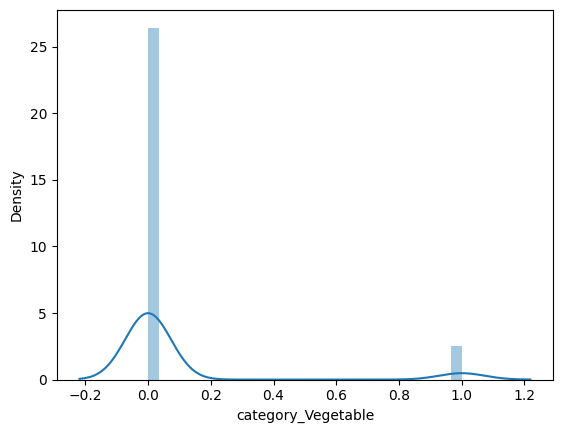

/tmp/ipykernel_8591/2609660079.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])


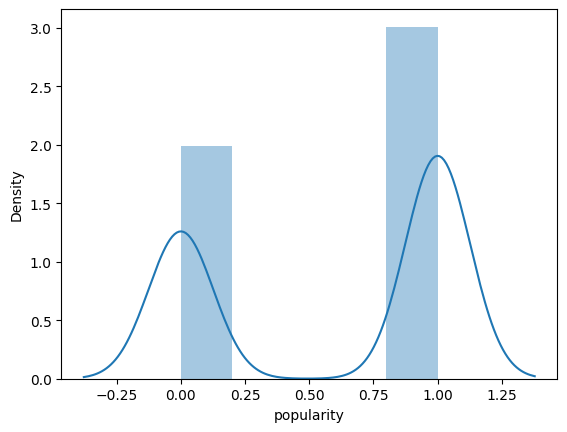

In [62]:

#plot distributions of calories, carbohydrate, sugar and protein
plot_distributions(df)

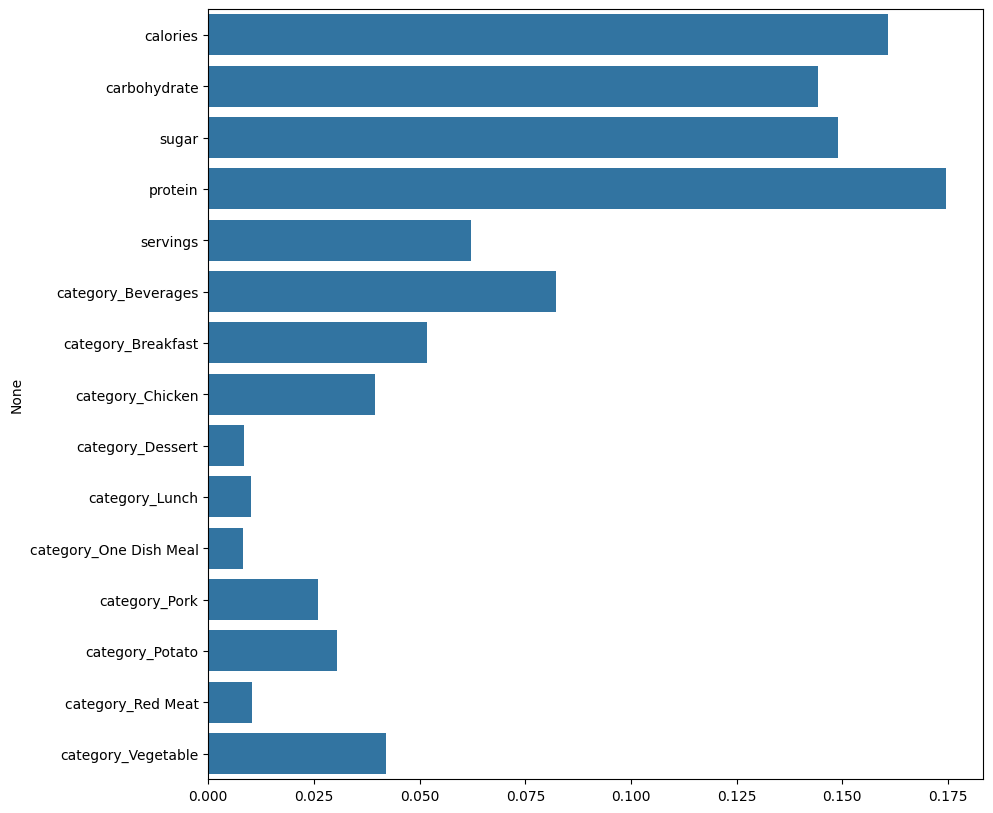

In [66]:
# perform feature importance with random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
X = df.drop('popularity', axis=1)
y = df['popularity']
rfc.fit(X, y)
rfc.feature_importances_

#plot feature importance
plt.figure(figsize=(10,10))
sns.barplot(x=rfc.feature_importances_, y=X.columns)
plt.show()


# Baselines

In [69]:
#do automl with h2o to see a list of models and baselines 
import h2o
from h2o.automl import H2OAutoML
h2o.init()
h2o_df = h2o.H2OFrame(df)
h2o_df['popularity'] = h2o_df['popularity'].asfactor()
h2o_df.head()
aml = H2OAutoML(max_models=20, seed=1)
aml.train(y='popularity', training_frame=h2o_df)
lb = aml.leaderboard
lb.head(rows=lb.nrows)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzsa1f7gt
  JVM stdout: /tmp/tmpzsa1f7gt/h2o_root_started_from_python.out
  JVM stderr: /tmp/tmpzsa1f7gt/h2o_root_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_root_yb5qz4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.828 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_1_20231016_10530_model_1,0.816254,0.562071,0.870414,0.283626,0.424114,0.179872
StackedEnsemble_BestOfFamily_1_AutoML_1_20231016_10530,0.812639,0.499815,0.867525,0.25369,0.409221,0.167462
StackedEnsemble_AllModels_1_AutoML_1_20231016_10530,0.812238,0.500002,0.867448,0.254626,0.409317,0.16754
GLM_1_AutoML_1_20231016_10530,0.810684,0.497239,0.864886,0.251793,0.408791,0.16711
GBM_grid_1_AutoML_1_20231016_10530_model_2,0.804628,0.514826,0.863178,0.260316,0.414971,0.172201
DeepLearning_grid_3_AutoML_1_20231016_10530_model_1,0.804328,0.619848,0.860891,0.296421,0.437026,0.190992
DeepLearning_grid_2_AutoML_1_20231016_10530_model_1,0.801551,0.563259,0.85823,0.289795,0.427377,0.182651
GBM_2_AutoML_1_20231016_10530,0.795742,0.527694,0.85453,0.374779,0.421722,0.177849
GBM_5_AutoML_1_20231016_10530,0.795493,0.525996,0.856746,0.362967,0.421303,0.177496
DRF_1_AutoML_1_20231016_10530,0.795344,0.536019,0.852962,0.323548,0.423287,0.179172


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


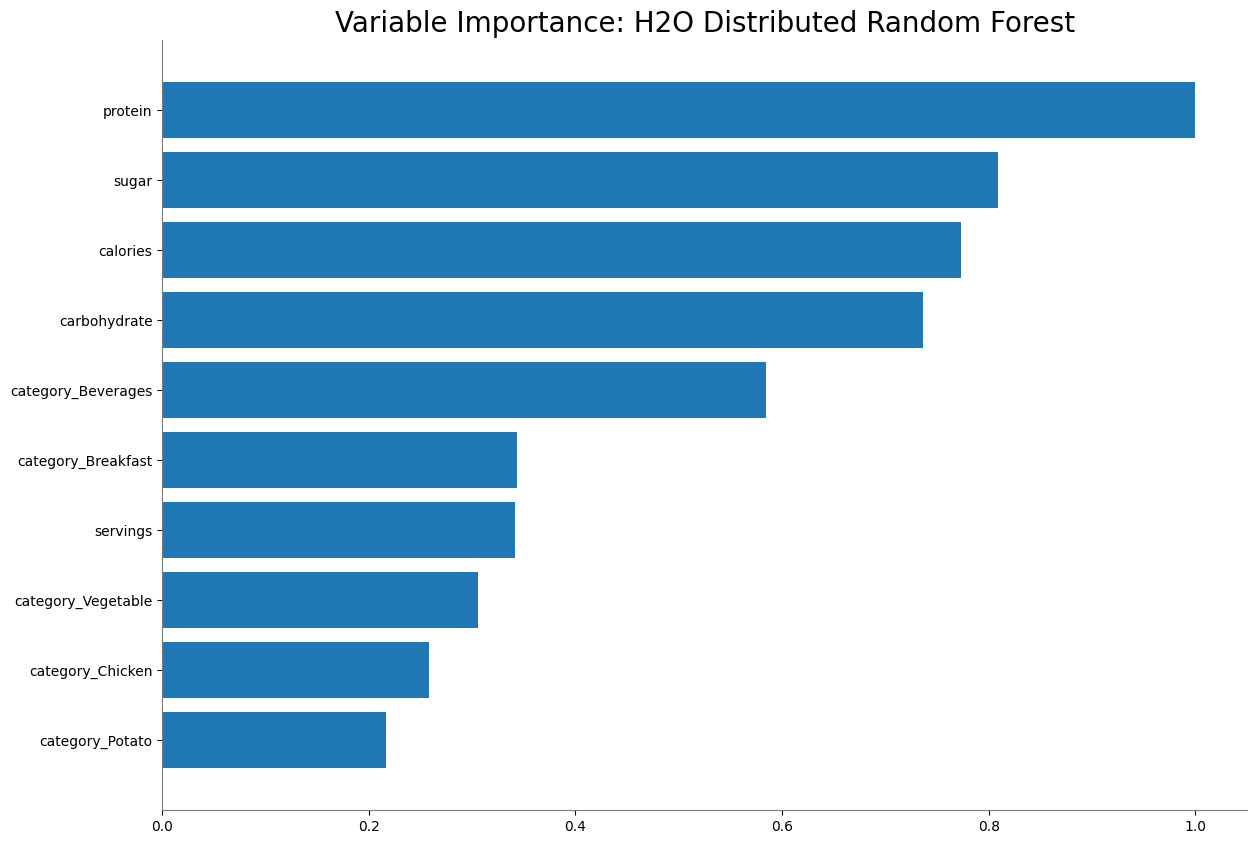

ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.17889009403195322
RMSE: 0.42295400935793626
LogLoss: 0.5405796823247536
Mean Per-Class Error: 0.3340150237132763
AUC: 0.7958615823704789
AUCPR: 0.8472561904265904
Gini: 0.5917231647409578

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30499698489904403
       0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  214  0.6062   (214.0/353.0)
1      33   501  0.0618   (33.0/534.0)
Total  172  715  0.2785   (247.0/887.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304997     0.802242  302
max f2                       0.155125     0.895345  350
max f0point5                 0.525899     0.782998  214
max accuracy                 0.511356     0.740699  217
max precision                1            1         0
max recall                   0.00582749   1         399
max specificity              1            1         0
max absolute_mcc             0.511356     0.455913  217
max min_per_class_accuracy   0.591246     0.711048  188
max mean_per_class_accuracy  0.525899     0.727536  214
max tns                      1            353       0
max fns                      1            532       0
max fps                      0.00582749   353       399
max tps                      0.00582749   534       399
max tnr                      1            1         0
max fnr                      1            0.996255  0
max fpr                      0.00582749   1         399
max tpr                      0.00582749   1         399

Gains/Lift Table: Avg response rate: 60.20 %, avg score: 59.61 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.011274                    0.997406           1.66105   1.66105            1                0.998104   1                           0.998104            0.0187266       0.0187266                  66.1049   66.1049            0.0187266
2        0.0214205                   0.992716           1.47649   1.57363            0.888889         0.994853   0.947368                    0.996564            0.0149813       0.0337079                  47.6488   57.3625            0.030875
3        0.0304397                   0.986791           1.45342   1.53801            0.875            0.988837   0.925926                    0.994275            0.0131086       0.0468165                  45.3418   53.8008            0.0411508
4        0.0417136                   0.98264            1.49494   1.52637            0.9              0.983937   0.918919                    0.991481            0.0168539       0.0636704                  49.4944   52.6369            0.0551718
5        0.0507328                   0.979485           1.66105   1.55031            1                0.980923   0.933333                    0.989604            0.0149813       0.0786517                  66.1049   55.0312            0.0701531
6        0.100338                    0.955828           1.58555   1.56773            0.954545         0.968669   0.94382                     0.979254            0.0786517       0.157303                   58.5546   56.7731            0.143139
7        0.149944                    0.92811            1.47229   1.53616            0.886364         0.941709   0.924812                    0.966833            0.0730337       0.230337                   47.2293   53.6158            0.202008
8        0.200676           

<Figure size 640x480 with 0 Axes>

In [71]:
#choose best model from leaderboard and train it
from h2o.estimators import H2ORandomForestEstimator
rf = H2ORandomForestEstimator(ntrees=100, max_depth=20, nfolds=5, seed=1)
rf.train(y='popularity', training_frame=h2o_df)
rf.varimp_plot()
 
  
#save model
h2o.save_model(model=rf, path='recipe_site_traffic_model', force=True)

#load model
model = h2o.load_model('recipe_site_traffic_model/DRF_model_python_1697411126935_2326')

#show model performance
model.model_performance()
 
    
#show model performance on training data
model.model_performance(train=True)
 
 
#show model performance on test data
model.model_performance(valid=True)
 
 
#show model performance on cross validation data
model.model_performance(xval=True)